# U-net with simple ResNet Blocks (Forked)

https://www.kaggle.com/divrikwicky/u-net-with-simple-resnet-blocks-forked

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img

In [17]:
from keras.callbacks import CSVLogger

## Data

### Set some parameters

In [2]:
# Set some parameters
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1
basicpath = './data/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

### Loading of training/testing ids and depths

In [4]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [6]:
train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

###  Plotting the coverage distributions

D:\Anaconda2\envs\py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


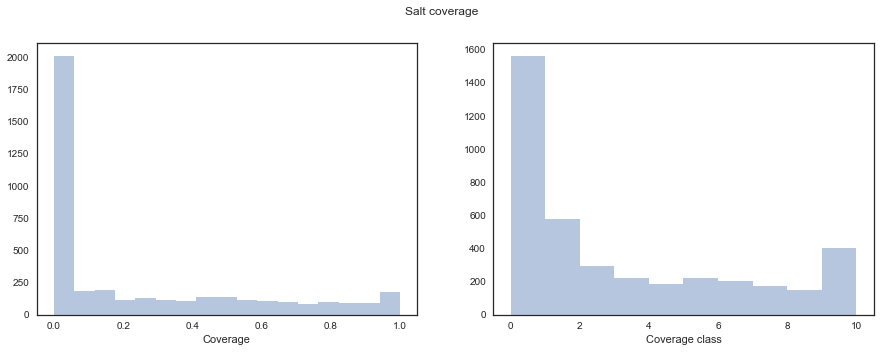

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

### Plotting the depth distributions

D:\Anaconda2\envs\py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


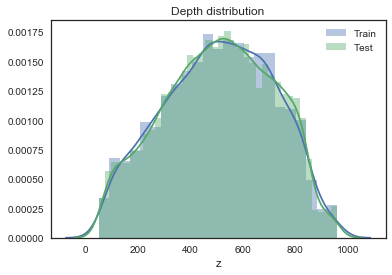

In [9]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

### Create train/validation split stratified by salt coverage

In [10]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

## Model

In [11]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation(ACTIVATION)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [12]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [13]:
thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

## Train

### Data augmentation

In [14]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


### fit

In [20]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [21]:
model_filepath = "005-model-resnet.hdf5"
log_filepath = "005-log-resnet.csv"

early_stopping = EarlyStopping(monitor='val_acc', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode = 'max', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
model_logger = CSVLogger(log_filepath, separator=',', append=False)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                    verbose=200)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
Epoch 00001: val_acc improved from -inf to 0.24894, saving model to 005-model-resnet.hdf5
Epoch 2/200
Epoch 00002: val_acc improved from 0.24894 to 0.67147, saving model to 005-model-resnet.hdf5
Epoch 3/200
Epoch 00003: val_acc improved from 0.67147 to 0.84168, saving model to 005-model-resnet.hdf5
Epoch 4/200
Epoch 00004: val_acc improved from 0.84168 to 0.91013, saving model to 005-model-resnet.hdf5
Epoch 5/200
Epoch 00005: val_acc did not improve
Epoch 6/200
Epoch 00006: val_acc improved from 0.91013 to 0.91540, saving model to 005-model-resnet.hdf5
Epoch 7/200
Epoch 00007: val_acc improved from 0.91540 to 0.92531, saving model to 005-model-resnet.hdf5
Epoch 8/200
Epoch 00008: val_acc improved from 0.92531 to 0.92976, saving model to 005-model-resnet.hdf5
Epoch 9/200
Epoch 00009: val_acc did not improve
Epoch 10/200
Epoch 00010: val_acc did not improve
Epoch 11/200
Epoch 00011: val_acc improved from 0.92976 to 0.93428, savin

### Learning curve

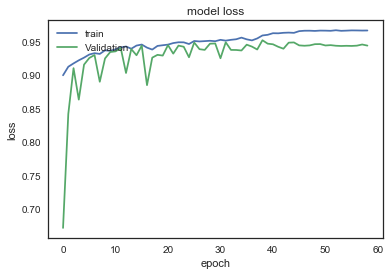

In [22]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

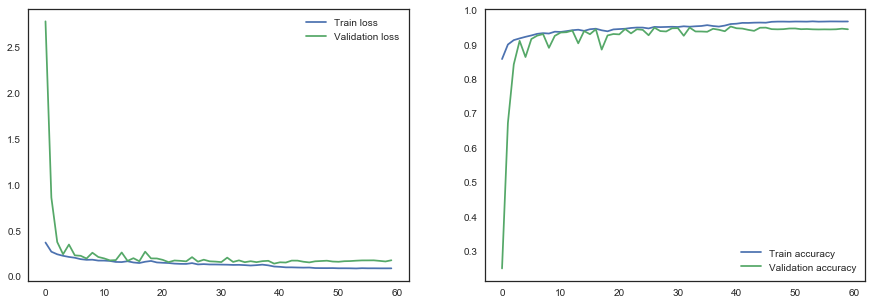

In [35]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.legend()
plt.show()

## Search Threshold

In [24]:
model = load_model(model_filepath)

In [25]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test/2.0

In [26]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [27]:
def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric(y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])

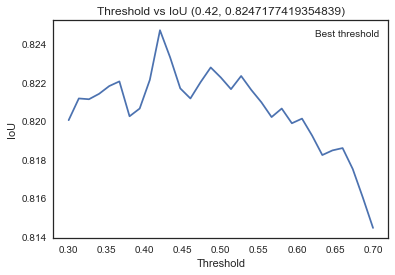

In [28]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

## Test

In [29]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [30]:
import gc

del x_train, x_valid, y_train, y_valid, preds_valid
gc.collect()

88591

In [31]:
x_test = np.array([(np.array(load_img("./data/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = predict_result(model,x_test,img_size_target)

In [32]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(filter_image(preds_test[i] > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 2.825890302658081 s


In [33]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('./result/005-submission.csv')

In [36]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,76 26 178 25 277 27 380 25 481 25 583 24 684 2...
52551f7a80,
512d8d9997,1 17 102 17 203 17 304 14 319 1 405 17 506 17 ...
64dba827d6,
0a3a8a5f37,
329563756f,1 97 102 99 203 99 304 99 405 99 506 99 607 99...
f6cba2e890,
